In [2]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [5]:
a = int(input('Считывать с катушек (0) или файла (1)?'))

In [6]:
if a:
    # Выбор порта данных с катушек
    ports = serial.tools.list_ports.comports()
    port = None
    # print(ports)
    for i, port in enumerate(ports):
        # print(f"{port}")
        print(f"Порт {i}: {port.device}")
        # print(f"Описание: {port.description}")
        # print(f"VID:PID: {port.vid}:{port.pid}")
    if port:
        # prt = int(input('Какой порт?'))
        port = ports[0].device
        port_motor = ports[1].device
        print(f'Для получения данных выбран порт - {port}')
        print(f'Для двигателя выбран порт - {port_motor}')

In [ ]:
if a:
    # Отправка команды на вращение магнита
    with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
        # Read data from COM port
        revolutions = 26
        distance=1000/9
        speed=100
        command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
        serialData.write(command.encode(encoding="utf-8"))

    # Чтение данных с катушек в память контроллера
    time.sleep(3)
    with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
        # Read data from COM port
        command = 'R'
        # Send the command to the DataPort
        serialData.write(command.encode(encoding="utf-8"))
        # serialline.flush()
    time.sleep(11)

    # Получение данных с выбранного порта в память компьютера
    rawdata_bytes = None
    with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=46)) as serialData:
        # Read data from COM port
        command = 'S'
        # Send the command to the DataPort
        serialData.write(command.encode())
        # Get data
        rawdata_bytes = serialData.read(4194304)
    
    rawdata = np.frombuffer(rawdata_bytes, dtype=np.uint8)

    raw_signal = rawdata[:2097152]
    # Чтение по два байта (старший-младший) в нотации "big-endian" с переводом в нотацию компилятора (little-endian)
    data = raw_signal.view(dtype='>i2').astype(np.int16)

    raw_encoder = rawdata[2097152:]
    encoder = raw_encoder.view(dtype='>i2').astype(np.int16)

    # df_raw = pd.DataFrame({
    #     'encoder': encoder,
    #     'data': data
    # })

    # Фильтрация данных от дельта-шумов
    window_size = 3
    trim_offset = window_size // 2

    # Применяем фильтр и обрезаем сразу для обоих столбцов
    # Создаем новый DataFrame с отфильтрованными данными
    df_filtered = pd.DataFrame({
        'encoder': medfilt(encoder, kernel_size=window_size)[trim_offset:-trim_offset],
        'data': medfilt(data, kernel_size=window_size)[trim_offset:-trim_offset]    
    })

    # Запись данных в файл
    try:
        os.mkdir('data')
    except FileExistsError:
        pass
    except Exception as e:
        print(f'Что-то пошло не так: {e}')

    filename = f"data_raw_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    dir = 'data'

    df_filtered.to_csv(os.path.join(dir, filename))

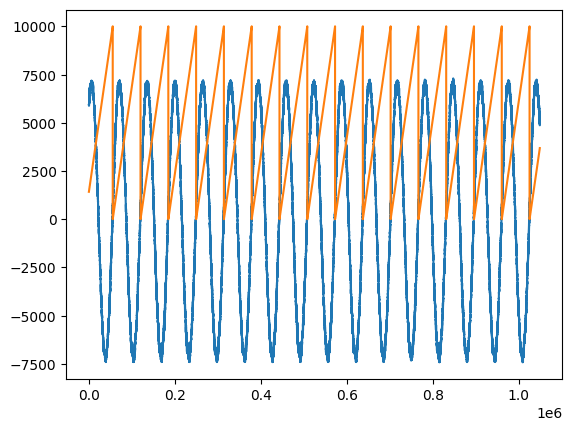

In [9]:
if not a:
    df_raw = pd.read_csv(os.path.join('data','data_raw.csv'), index_col=0)

    # Фильтрация данных от дельта-шумов
    df_filtered = pd.DataFrame()
    window_size = 3
    trim_offset = window_size // 2

    # Применяем фильтр и обрезаем сразу для обоих столбцов
    # Создаем новый DataFrame с отфильтрованными данными
    df_filtered['data'] = medfilt(df_raw.data, kernel_size=window_size)[trim_offset:-trim_offset]
    df_filtered['encoder'] = medfilt(df_raw.encoder, kernel_size=window_size)[trim_offset:-trim_offset]

    %matplotlib inline
    df_filtered.data.plot()
    df_filtered.encoder.plot()

In [8]:
if 0:
    split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
    start_idx = split_points[0]
    end_idx = split_points[-1]
    df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

In [10]:
# Отрезаем целое число периодов

# индексы, где энкодер "прыгнул"
diff_enc = df_filtered['encoder'].shift(1) - df_filtered['encoder']
split_points = df_filtered.index[diff_enc.abs() > 1000]  # по модулю, чтобы не зависить от направления (?)

print(f'Найдено {len(split_points)-1} периодов энкодера')

if len(split_points) in (0, 1):
    print("Warning: Нет переходов нуля энкодера.")
    df_trimmed = df_filtered.copy()
else:
    start_idx = split_points[0]
    end_idx = split_points[-1]
    # Проверка, чтобы start_idx был меньше end_idx
    if start_idx >= end_idx:
        print(f"Warning: start_idx ({start_idx}) >= end_idx ({end_idx}). Returning original DataFrame.")
        df_trimmed = df_filtered.copy()
    else:
        df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

Найдено 15 периодов энкодера


In [11]:
if 0:    
    # Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
    # Добавим столбец, который идентифицирует периоды непрерывных значений encoder
    df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

    # Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
    df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

    df_res['integral'] = -1.0*df_res.data.cumsum()

    # 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
    df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res.integral

    df_res['deg'] = df_res.index/10000*360

In [11]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
# 1. Группировка по периодам (непрерывные одинаковые значения encoder)
df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

# 2. Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'first'}).reset_index(drop=True)

# 3. Интеграл (кумулятивная сумма)
df_res['integral'] = -1.0*df_res.data.cumsum()

# from scipy import integrate
# dt = 1
# df_res['integral'] = -1.0 * integrate.cumulative_trapezoid(df_res['data'], dx=dt, initial=0)

# 4. Пересчет в Вольты*метры*секунды
#  2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res['integral']

# 5. Угол в градусах
df_res['deg'] = (df_res['encoder']/10000)*360

In [12]:
# FastGoertzel

import fastgoertzel as fg

amp_fg, phase_fg = fg.goertzel(df_res.volts.values, 1/10000)
phase_fgd = (phase_fg+np.pi/2)*180/np.pi

df_res['goertzel'] = amp_fg * np.cos(2*np.pi * 1/10000 * df_res.index.values + phase_fg)

print(f'FastGoertzel Amp: {amp_fg:.6e}, {phase_fgd = :.3f}°')

FastGoertzel Amp: 5.031259e-05, phase_fgd = 94.575°


In [13]:
# SlowGoertzel

PT = 10000 # точек на период
N = len(df_res)-len(df_res)%PT # 150000 количество отсчетов
# omega0 = 2*np.pi/PT # угловая частота
k = int(N/PT) # номер гармоники
alpha = 2*np.cos(2*np.pi*k/N)

print(f'{N=}, {PT=}, {k=}, {alpha=:}')

result = df_res.copy()

signal = 'volts'

result['s'] = 0.0

n = 0
result.loc[n, 's'] = result.loc[n, signal] + alpha*0 - 0
n = 1
result.loc[n, 's'] = result.loc[n, signal] + alpha*result.loc[n-1, 's'] - 0

for n in range(2, len(result)):
    result.loc[n, 's'] = result.loc[n, signal] + alpha*result.loc[n-1, 's'] - result.loc[n-2, 's']

F2 = result.loc[N-1, 's']
F3 = result.loc[N-2, 's']

real = F2*np.cos(2*np.pi*k/N)-F3
imag = F2*np.sin(2*np.pi*k/N)

amp_sg = np.sqrt(real**2 + imag**2)*2/N 
phase_sgd = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

# amp = 1/1144.8 * amp # 2.5/32767 - Volts ; 1/96937 - sec ; 1/1144.8 - m
print(f'SlowGoertzel Amp: {amp_sg:.6e}, {phase_sgd = :.3f}°')

N=150000, PT=10000, k=15, alpha=1.9999996052158369
SlowGoertzel Amp: 5.031259e-05, phase_sgd = 94.575°


In [15]:
# Детрендирование и поиск экстремумов
x_tr = df_res.index
y_tr = df_res.volts.values

# Координаты первой и последней точек
x0, x1 = x_tr[0], x_tr[-1]
y0, y1 = y_tr[0], y_tr[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем тренд
df_res['trend'] = a * x_tr + b

# Детрендированные данные
df_res['detrended'] = (df_res.volts - df_res.trend)

df = df_res.copy()
# Локальные максимумы
local_maxima = argrelextrema(df.detrended.values, np.greater, order=100)[0]
# Локальные минимумы
local_minima = argrelextrema(df.detrended.values, np.less, order=100)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df['is_local_max'] = False
df['is_local_min'] = False

df.loc[local_maxima, 'is_local_max'] = True
df.loc[local_minima, 'is_local_min'] = True

data = 'detrended'

# Извлечение экстремумов
maxima = df[df['is_local_max']]
minima = df[df['is_local_min']]

# Вычисляем средние значения
mean_max = maxima[data].mean()
mean_min = minima[data].mean()

# Разность средних
amp_peak = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima[data].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima[data].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amp_peak * 100  # в процентах

# print(f"   Амплитуда = {amp_peak:.6} ± {absolute_error:.2}")
# print(f"   Относительная погрешность: {relative_error:.4f}%")
print(f'Peak Amp: {amp_peak:.6e}')

Найдено локальных максимумов: 15
Найдено локальных минимумов: 15
Peak Amp: 5.026907e-05


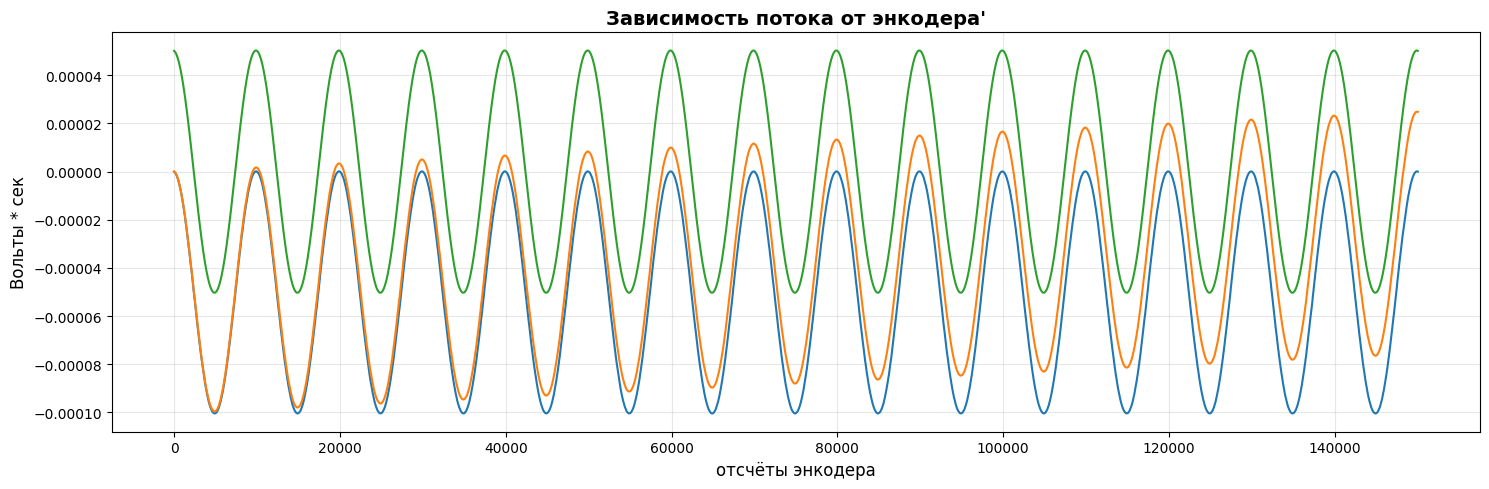

In [16]:
%matplotlib inline
# Создаем график с настройками
plt.figure(figsize=(15, 5))
# Добавляем заголовок и подписи осей
plt.title("Зависимость потока от энкодера'", fontsize=14, fontweight='bold')
plt.xlabel("отсчёты энкодера", fontsize=12)
plt.ylabel("Вольты * сек", fontsize=12)

plt.grid(True, alpha=0.3) # Улучшаем сетку

plt.plot(df_res.detrended)
plt.plot(df_res.volts)
plt.plot(df_res.goertzel)

# Показываем график
plt.tight_layout()
plt.show()

In [17]:
print(f'FastGoertzel Amp: {amp_fg:.6e}, {phase_fgd = :.3f}°')
print(f'SlowGoertzel Amp: {amp_sg:.6e}, {phase_sgd = :.3f}°')
print(f'Peak Amp        : {amp_peak:.6e}')

FastGoertzel Amp: 5.031259e-05, phase_fgd = 94.575°
SlowGoertzel Amp: 5.031259e-05, phase_sgd = 94.575°
Peak Amp        : 5.026907e-05


In [18]:
# Если частота основной гармоники известна (например, f0)
# Предположим, что f0 — это нормированная частота (например, 1/10000, как в вашем примере с goertzel), или вы знаете fs и f0.

# import numpy as np

# Пример: f0 — нормированная частота (f_target / fs)
f0_norm = 1 / 10000  # как в вашем случае
N = len(df_res.volts.values)
n = np.arange(N)

# Вычисляем комплексный коэффициент Фурье
# exp(-j*2*pi*f*n) — базисная функция для частоты f
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * f0_norm * n))

amplitude = abs(C)
phase_rad = np.angle(C)+np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (rad): {phase_rad:.3f}')
print(f'Phase (deg): {phase_deg:.3f}°')

Amplitude: 5.03126e-05
Phase (rad): 1.651
Phase (deg): 94.575°


In [19]:
# Если частота неизвестна, и нужно найти основную гармонику
# Выполнить FFT и найти пик:

# import numpy as np

signal = df_res.volts.values
N = len(signal)
fft_vals = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/96937)  # d=1, если шаг по времени = 1, иначе d=dt

# Находим амплитуду и фазу для частоты с максимальной амплитудой (основная гармоника)
# Ищем только положительные частоты
positive_freqs = freqs[:N//2]
fft_vals_half = fft_vals[:N//2]

# Индекс максимальной амплитуды
max_idx = np.argmax(np.abs(fft_vals_half))

amplitude = 2 * abs(fft_vals_half[max_idx]) / N  # 2/N для амплитуды синусоиды
phase_rad = np.angle(fft_vals_half[max_idx]) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

freq_main = positive_freqs[max_idx]  # частота основной гармоники

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 0.0
Amplitude: 7.56325e-05
Phase (deg): 270.000°


In [20]:
# 3: Использовать scipy.signal.periodogram или welch
# Если вы хотите оценить спектр и найти пик, scipy предоставляет удобные функции:

from scipy.signal import periodogram
# import numpy as np

fs = 10000  # например, частота дискретизации (или используйте 1, если нормирована)
frequencies, power = periodogram(df_res.volts.values, fs=fs)

max_idx = np.argmax(power)
freq_main = frequencies[max_idx]
amplitude = np.sqrt(power[max_idx]) * 2  # приблизительная амплитуда

# Для фазы всё равно нужно вычислить комплексный коэффициент на freq_main
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * freq_main / fs * np.arange(N)))
phase_rad = np.angle(C) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 1.0
Amplitude: 2.75573e-04
Phase (deg): 94.575°
